#### maizeでケモインフォマティクスのWFを作成してみる
- 02_hello_maizeをベースにrdkitを利用するワークフローを作って見ましょう。
- まず必要なライブラリ軍をインポートします

In [ ]:
#import setenv # XDG_CONFIG_HOMEの設定がうまく行かない場合
from pathlib import Path
from maize.core.workflow import Workflow
from maize.core.node import Node
from maize.steps.io import LoadData, LogResult, Void, FileParameter, Return
from maize.steps.mai.molecule import LoadSmiles, LoadMolecule, Gypsum
from maize.core.interface import Input, Output
from maize.utilities.chem import IsomerCollection
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
from pandas import DataFrame

#### 作成するワークフローの概要
- LoadDataノードは先の例では、Intを受け取りましたが、今度はSMILESを受け取り次のノードに渡します。
- 次のノードはCalcDescという名前にし、受け取った文字列（SMILESのリスト）をRDKit のMolオブジェクトに変換、記述を計算するようにしましょう。
- 最後に計算した値をPandasのデータフレームで返します。
- 最低限、MolWt, MolLogPを計算する関数を組み込んでみましょう。

#### ノードを書いてみる時間を少し取ります。
- TIPS RDKitで計算可能な記述子リストは以下のように多数あります。

In [2]:
for desc in Descriptors._descList:
    print(desc)

('MaxAbsEStateIndex', <function MaxAbsEStateIndex at 0x747fcd2f3130>)
('MaxEStateIndex', <function MaxEStateIndex at 0x747fcd2f3010>)
('MinAbsEStateIndex', <function MinAbsEStateIndex at 0x747fcd2f31c0>)
('MinEStateIndex', <function MinEStateIndex at 0x747fcd2f30a0>)
('qed', <function qed at 0x747fcd329fc0>)
('SPS', <function SPS at 0x747fcd32a320>)
('MolWt', <function <lambda> at 0x747fcd32a950>)
('HeavyAtomMolWt', <function HeavyAtomMolWt at 0x747fcd32a9e0>)
('ExactMolWt', <function <lambda> at 0x747fcd32aa70>)
('NumValenceElectrons', <function NumValenceElectrons at 0x747fcd32ab00>)
('NumRadicalElectrons', <function NumRadicalElectrons at 0x747fcd32ab90>)
('MaxPartialCharge', <function MaxPartialCharge at 0x747fcd32acb0>)
('MinPartialCharge', <function MinPartialCharge at 0x747fcd32ad40>)
('MaxAbsPartialCharge', <function MaxAbsPartialCharge at 0x747fcd32add0>)
('MinAbsPartialCharge', <function MinAbsPartialCharge at 0x747fcd32ae60>)
('FpDensityMorgan1', <function FpDensityMorgan1 a

In [3]:
class CalcDesc(Node):
    out: Output[pd.DataFrame] = Output()
    inp: Input[list[str]] = Input()

    def run(self):
        res = pd.DataFrame({'smiles': self.inp.receive()})
        res['ROMol'] = res['smiles'].apply(Chem.MolFromSmiles)
        res['MolWt'] = res['ROMol'].apply(Descriptors.MolWt)
        res['MolLogP'] = res['ROMol'].apply(Descriptors.MolLogP)
        return self.out.send(res)

In [4]:
mols = ['CCC', 'CCOC', 'CCCC']

#### ワークフロー構築
- CalcDescノードの定義が終わったらワークフローを構築しましょう
- 非常にシンプルな例ですがLoadDataの出力をCalcDesc2私最後にそれをReturnノードで受け取るというワークフローです

In [5]:
flow = Workflow()
load = flow.add(LoadData[list[str]])
calc = flow.add(CalcDesc)
res = flow.add(Return[pd.DataFrame])
flow.connect(load.out, calc.inp)
flow.connect(calc.out, res.inp)
load.data.set(mols)
flow.check()

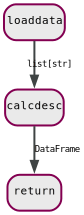

In [6]:
flow.visualize()

In [7]:
flow.execute()

2024-10-28 14:47:16,147 |     INFO |           ww8dtn | 
              ___           ___                       ___           ___
             /\__\         /\  \          ___        /\  \         /\  \
            /::|  |       /::\  \        /\  \       \:\  \       /::\  \
           /:|:|  |      /:/\:\  \       \:\  \       \:\  \     /:/\:\  \
          /:/|:|__|__   /::\~\:\  \      /::\__\       \:\  \   /::\~\:\  \
         /:/ |::::\__\ /:/\:\ \:\__\  __/:/\/__/ _______\:\__\ /:/\:\ \:\__\
         \/__/~~/:/  / \/__\:\/:/  / /\/:/  /    \::::::::/__/ \:\~\:\ \/__/
               /:/  /       \::/  /  \::/__/      \:\~~\~~      \:\ \:\__\
              /:/  /        /:/  /    \:\__\       \:\  \        \:\ \/__/
             /:/  /        /:/  /      \/__/        \:\__\        \:\__\
             \/__/         \/__/                     \/__/         \/__/


2024-10-28 14:47:16,148 |     INFO |           ww8dtn | Starting Maize version 0.8.3 (c) AstraZeneca 2024
2024-10-28 14:4

In [8]:
res.get()

,smiles,ROMol,MolWt,MolLogP
0,CCC,<rdkit.Chem.rdchem.Mol object at 0x747fcc2997b0>,44.097,1.4163
1,CCOC,<rdkit.Chem.rdchem.Mol object at 0x747fcbeb98f0>,60.096,0.6527
2,CCCC,<rdkit.Chem.rdchem.Mol object at 0x747fcbeb9940>,58.124,1.8064


#### maize-contribに実装されているIsomerCollectionを利用したワークフローの作成
- maize-contribには[IsomerCollection](https://github.com/MolecularAI/maize-contrib/blob/6a80f85e29e1d7e67bd13a2d34a0d5a440386fe3/maize/utilities/chem/chem.py#L1862)というクラスが実装されています。
- これはMaestro, SDF, SMILESなど様々な形式の入力を受け取りMolobjectを生成します。SMILESで受け取った場合は立体異性体のEnumerationも実施します。またこの際にRDKITを利用した立体構造生成も同時に行います。

In [9]:
from maize.utilities.chem.chem import IsomerCollection

In [10]:
iso1 = IsomerCollection.from_smiles('CCC(O)CN')

In [11]:
iso1

IsomerCollection('CCC(O)CN', n_isomers=2)

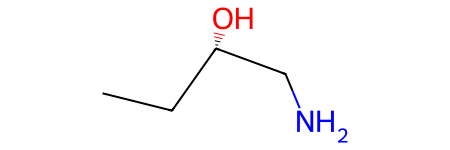

In [12]:
iso1.molecules[0]._molecule

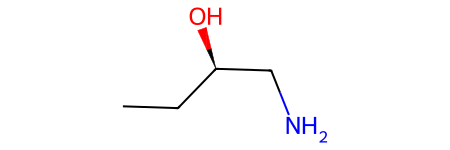

In [13]:
iso1.molecules[1]._molecule

In [14]:
print(Chem.MolToMolBlock(iso1.molecules[0]._molecule))


     RDKit          3D

  6  5  0  0  0  0  0  0  0  0999 V2000
   -2.1384   -0.1968   -0.3314 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.7490   -0.5431    0.1705 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.1305    0.7001    0.2597 C   0  0  2  0  0  0  0  0  0  0  0  0
    0.2686    1.3050   -0.9779 O   0  0  0  0  0  0  0  0  0  0  0  0
    1.5218    0.1884    0.6540 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.9149   -0.7560   -0.3866 N   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0
  2  3  1  0
  3  4  1  6
  3  5  1  0
  5  6  1  0
M  END



In [15]:
#### SMILESを入力としてIsomerCollectionを返すノードを書いてみて下さい

In [16]:
class Smi2Mols(Node):
    inp: Input[list[str]] = Input()
    out: Output[list[IsomerCollection]] = Output()

    def run(self) -> None:
        smiles_list = self.inp.receive()
        mols = [IsomerCollection.from_smiles(smi) for smi in smiles_list]
        self.out.send(mols)

In [17]:
flow = Workflow()
load = flow.add(LoadData[list[str]])
emb = flow.add(Smi2Mols)
ret = flow.add(Return[list[IsomerCollection]])
flow.connect(load.out, emb.inp)
flow.connect(emb.out, ret.inp)
load.data.set(['CC', 'CCC(O)CN'])
flow.check()

In [18]:
flow.execute()

2024-10-28 14:53:18,075 |     INFO |           76mhne | 
              ___           ___                       ___           ___
             /\__\         /\  \          ___        /\  \         /\  \
            /::|  |       /::\  \        /\  \       \:\  \       /::\  \
           /:|:|  |      /:/\:\  \       \:\  \       \:\  \     /:/\:\  \
          /:/|:|__|__   /::\~\:\  \      /::\__\       \:\  \   /::\~\:\  \
         /:/ |::::\__\ /:/\:\ \:\__\  __/:/\/__/ _______\:\__\ /:/\:\ \:\__\
         \/__/~~/:/  / \/__\:\/:/  / /\/:/  /    \::::::::/__/ \:\~\:\ \/__/
               /:/  /       \::/  /  \::/__/      \:\~~\~~      \:\ \:\__\
              /:/  /        /:/  /    \:\__\       \:\  \        \:\ \/__/
             /:/  /        /:/  /      \/__/        \:\__\        \:\__\
             \/__/         \/__/                     \/__/         \/__/


2024-10-28 14:53:18,076 |     INFO |           76mhne | Starting Maize version 0.8.3 (c) AstraZeneca 2024
2024-10-28 14:5

In [19]:
results = ret.get()

In [20]:
results

[IsomerCollection('CC', n_isomers=1),
 IsomerCollection('CCC(O)CN', n_isomers=2)]

#### Appendix XTB calculation
- このコードを利用するためには同じ環境下に追加でXTBをインストールする必要があります
- [XTB](https://xtb-docs.readthedocs.io/en/latest/)は半経験的な量子科学計算のパッケージです。
- Maizeを利用することで入力部分の作成に労を割くことなく計算を実施できます。
- 入力はSMILESとし、そのSMILESをGypSumで3次元化次いでXTBでの計算を流すというワークフローになります。
- 
```bash
conda install -c conda-forge xtb
```

In [ ]:
from maize.steps.mai.molecule.xtb import Xtb

class SetName(Node):
    inp: Input[list[IsomerCollection]] = Input()
    out: Output[list[IsomerCollection]] = Output()
    def run(self):
        res = []
        for i, iso in enumerate(self.inp.receive()):
            iso.set_tag('component', f'mol_{i}')
            res.append(iso)

        self.out.send(res)

In [ ]:
flow = Workflow(name='xtb', cleanup_temp=True)
load = flow.add(LoadData[list[str]])
# あとでGypSumの説明をしますが、このノードも配座発生に利用するノードです。
emb = flow.add(Gypsum)
setname = flow.add(SetName)
qm = flow.add(Xtb)
res = flow.add(Return[list[IsomerCollection]])
# 入力はSMILESリストとしています
load.data.set(['c1ccccc1', 'c1cnccc1'])
# xtbノードは内部で並列処理をするのですがデフォルトで100並列の設定になっておりそのまま実施すると100 coreない場合エラーになります。
qm.n_jobs.set(5)
# 計算結果を格納するフォルダを指定します。
qm.fold.set('./xtbres')

In [ ]:
flow.connect(load.out, emb.inp)
flow.connect(emb.out, setname.inp)
flow.connect(setname.out, qm.inp)
flow.connect(qm.out, res.inp)
flow.check()

In [ ]:
flow.visualize()

In [ ]:
flow.execute()

In [ ]:
res.get()[0].molecules[0]._molecule